# Airbnb Recommendation System - Tokyo

# Business Problem
Airbnb wants to know which properties were popular in Tokyo and use that data to create more. 
Users also want to see which one to stay at.

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import surprise
from surprise.prediction_algorithms import *
from surprise import accuracy, Dataset, Reader, BaselineOnly

from surprise.model_selection import cross_validate, train_test_split
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline, NMF
from surprise.model_selection import GridSearchCV

from wordcloud import WordCloud
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

Detailed Review Data

In [2]:
file_path = file_path = '/Users/harshithathota/Documents/Capstone/data/reviews 2.csv'

reviews_df = pd.read_csv(file_path)

In [3]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451682 entries, 0 to 451681
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     451682 non-null  int64 
 1   id             451682 non-null  int64 
 2   date           451682 non-null  object
 3   reviewer_id    451682 non-null  int64 
 4   reviewer_name  451681 non-null  object
 5   comments       451638 non-null  object
dtypes: int64(3), object(3)
memory usage: 20.7+ MB


In [4]:
reviews_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,197677,554285,2011-09-21,1002142,Pablo,Couldn’t get any better!\r<br/>\r<br/>The apar...
1,197677,627651,2011-10-14,1031940,Ana & Ricardo,The apartment is bigger than it looks in the p...
2,197677,733040,2011-11-21,1097040,Samuel,The appartement is perfect for a couple! It is...
3,197677,755841,2011-11-30,1183674,Lisa,We had a terrific stay at Yoshimi and Marek's ...
4,197677,852938,2012-01-09,1538004,Langan,We loved our stay at the Oshiage Holiday Apart...


Detailed Listings data

In [5]:
listings = '/Users/harshithathota/Documents/Capstone/data/listings (1).csv'
listings = pd.read_csv(listings)

In [6]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12234 entries, 0 to 12233
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            12234 non-null  int64  
 1   listing_url                                   12234 non-null  object 
 2   scrape_id                                     12234 non-null  int64  
 3   last_scraped                                  12234 non-null  object 
 4   source                                        12234 non-null  object 
 5   name                                          12234 non-null  object 
 6   description                                   12234 non-null  object 
 7   neighborhood_overview                         8400 non-null   object 
 8   picture_url                                   12234 non-null  object 
 9   host_id                                       12234 non-null 

In [7]:
listings.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,197677,https://www.airbnb.com/rooms/197677,20230924051543,2023-09-24,city scrape,Rental unit in Sumida · ★4.77 · 1 bedroom · 2 ...,<b>The space</b><br />We are happy to welcome ...,NaN,https://a0.muscache.com/pictures/38437056/d27f...,964081,...,4.83,4.53,4.79,M130003350,f,1,1,0,0,1.19
1,5240174,https://www.airbnb.com/rooms/5240174,20230924051543,2023-09-24,previous scrape,Rental unit in Shibuya-ku · ★4.52 · Studio · 1...,Minimalist simple grey-color interior room. My...,NaN,https://a0.muscache.com/pictures/b0b55fef-80cb...,24477517,...,4.83,4.29,4.30,M130005396,t,4,4,0,0,1.89
2,5262640,https://www.airbnb.com/rooms/5262640,20230924051543,2023-09-24,city scrape,Rental unit in Nakano-ku · ★4.80 · 1 bedroom ·...,It takes 5 min walk to Fujimidai Sta.. You can...,No smoking in the room<br />No outdoor shoes a...,https://a0.muscache.com/pictures/281f8d6f-eb4a...,17736560,...,4.87,4.61,4.77,Hotels and Inns Business Act | 中野区保健所 | 30中環生環...,f,9,9,0,0,0.59
3,776070,https://www.airbnb.com/rooms/776070,20230924051543,2023-09-24,city scrape,Home in Kita-ku · ★4.98 · 1 bedroom · 1 bed · ...,We have been in airbnb since 2011 and it has g...,We love Nishinippori because is nearer to Toky...,https://a0.muscache.com/pictures/efd9f039-dbd2...,801494,...,4.98,4.84,4.91,M130000243,f,1,0,1,0,1.88
4,905944,https://www.airbnb.com/rooms/905944,20230924051543,2023-09-24,city scrape,Rental unit in Shibuya · ★4.77 · 2 bedrooms · ...,NEWLY RENOVATED property entirely for you & yo...,Hatagaya is a great neighborhood located 4 min...,https://a0.muscache.com/pictures/miso/Hosting-...,4847803,...,4.91,4.78,4.78,Hotels and Inns Business Act | 渋谷区保健所長 | 31渋健生...,t,5,5,0,0,1.52


# EDA

* We only need the reviews and listings datasets

In [10]:
merged_df = pd.merge(reviews_df, listings, left_on='listing_id', right_on='id', how='inner')
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451682 entries, 0 to 451681
Data columns (total 81 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   listing_id                                    451682 non-null  int64  
 1   id_x                                          451682 non-null  int64  
 2   date                                          451682 non-null  object 
 3   reviewer_id                                   451682 non-null  int64  
 4   reviewer_name                                 451681 non-null  object 
 5   comments                                      451638 non-null  object 
 6   id_y                                          451682 non-null  int64  
 7   listing_url                                   451682 non-null  object 
 8   scrape_id                                     451682 non-null  int64  
 9   last_scraped                                  45

In [9]:
merged_df.head()

,listing_id,id_x,date,reviewer_id,reviewer_name,comments,id_y,listing_url,scrape_id,last_scraped,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,197677,554285,2011-09-21,1002142,Pablo,Couldn’t get any better!\r<br/>\r<br/>The apar...,197677,https://www.airbnb.com/rooms/197677,20230924051543,2023-09-24,...,4.83,4.53,4.79,M130003350,f,1,1,0,0,1.19
1,197677,627651,2011-10-14,1031940,Ana & Ricardo,The apartment is bigger than it looks in the p...,197677,https://www.airbnb.com/rooms/197677,20230924051543,2023-09-24,...,4.83,4.53,4.79,M130003350,f,1,1,0,0,1.19
2,197677,733040,2011-11-21,1097040,Samuel,The appartement is perfect for a couple! It is...,197677,https://www.airbnb.com/rooms/197677,20230924051543,2023-09-24,...,4.83,4.53,4.79,M130003350,f,1,1,0,0,1.19
3,197677,755841,2011-11-30,1183674,Lisa,We had a terrific stay at Yoshimi and Marek's ...,197677,https://www.airbnb.com/rooms/197677,20230924051543,2023-09-24,...,4.83,4.53,4.79,M130003350,f,1,1,0,0,1.19
4,197677,852938,2012-01-09,1538004,Langan,We loved our stay at the Oshiage Holiday Apart...,197677,https://www.airbnb.com/rooms/197677,20230924051543,2023-09-24,...,4.83,4.53,4.79,M130003350,f,1,1,0,0,1.19


In [10]:
merged_df.isna().sum()

listing_id                                      0
id_x                                            0
date                                            0
reviewer_id                                     0
reviewer_name                                   1
                                               ..
calculated_host_listings_count                  0
calculated_host_listings_count_entire_homes     0
calculated_host_listings_count_private_rooms    0
calculated_host_listings_count_shared_rooms     0
reviews_per_month                               0
Length: 81, dtype: int64

Some of the reviews are from 2011, we only want the recent ones

In [11]:
merged_df['date'].value_counts()

date
2023-07-30    931
2023-08-14    850
2023-07-17    848
2023-05-06    832
2023-05-07    829
             ... 
2014-12-20      1
2013-12-15      1
2014-01-10      1
2014-01-18      1
2011-09-21      1
Name: count, Length: 3682, dtype: int64

* Checking num_of_reviews column. Will need to filter this by at least 10 reviews

In [11]:
merged_df['listing_id'].value_counts()

listing_id
27750681              2023
49084102               971
44125369               966
44637473               782
25377337               779
                      ... 
41653901                 1
41805631                 1
924340394945850701       1
41573195                 1
983031277017558192       1
Name: count, Length: 10776, dtype: int64

In [12]:
merged_df["listing_id"].nunique()

10776

* Looking at property_type columns.

In [13]:
merged_df['property_type'].value_counts()

property_type
Entire rental unit                    246883
Entire home                            64144
Private room in home                   21650
Private room in rental unit            16571
Entire condo                           13891
Room in hotel                          13041
Room in aparthotel                     12902
Room in boutique hotel                 12768
Entire serviced apartment               8245
Private room in hostel                  5816
Entire villa                            4639
Room in hostel                          4053
Private room in serviced apartment      3736
Shared room in hostel                   3608
Shared room in rental unit              2403
Entire loft                             2233
Private room in condo                   1478
Private room in guesthouse              1473
Entire townhouse                        1281
Hut                                     1257
Room in ryokan                          1034
Shared room in home                      

In [14]:
merged_df['number_of_reviews'].value_counts()

number_of_reviews
37     3367
36     3240
39     3120
41     3116
19     3116
       ... 
236     236
226     226
224     224
205     205
202     202
Name: count, Length: 351, dtype: int64

# Data Processing

In [13]:
# Convert date column to datetime
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Filter by date since May 1, 2023
merged_df = merged_df[merged_df['date'] >= '2023-05-01']

# Filter by number of reviews
merged_df = merged_df[merged_df['number_of_reviews'] > 10]

# drop unnecessary columns
col = ['id_x', 'id_y', 'source', 'host_id', 'host_name', 'calculated_host_listings_count', 'availability_365', 'host_id', 'host_url',
       'host_listings_count', 'host_total_listings_count', 'scrape_id', 'last_scraped',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_group_cleansed',  'minimum_nights',
       'calendar_updated', 
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'calendar_last_scraped',
       'first_review', 'last_review',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value',
       'license', 'instant_bookable',
       'calculated_host_listings_count', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 
       'reviews_per_month', 'host_since', 'host_location', 'host_thumbnail_url', 'host_picture_url','host_neighbourhood',
       'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms',
       'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'                                           
       ]

merged_df.drop(col, axis=1, inplace=True)

# rename columns
merged_df.rename(columns={'review_scores_rating': 'rating', 'accomodates': 'guest_limit', 'neighbourhood_cleansed': 'neighborhood'}, inplace=True)


In [14]:
# sanity check
merged_df = merged_df.reset_index(drop=True)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74975 entries, 0 to 74974
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   listing_id              74975 non-null  int64         
 1   date                    74975 non-null  datetime64[ns]
 2   reviewer_id             74975 non-null  int64         
 3   reviewer_name           74975 non-null  object        
 4   comments                74965 non-null  object        
 5   listing_url             74975 non-null  object        
 6   name                    74975 non-null  object        
 7   description             74975 non-null  object        
 8   neighborhood_overview   54749 non-null  object        
 9   picture_url             74975 non-null  object        
 10  neighborhood            74975 non-null  object        
 11  latitude                74975 non-null  float64       
 12  longitude               74975 non-null  float6

In [15]:
# Rename the dataframe to appropriate name and save cleaned dataset as CSV
df = merged_df
#df.to_csv('data/airbnb_listings.csv', index=False)

In [22]:
df.head()

,listing_id,date,reviewer_id,reviewer_name,comments,listing_url,name,description,neighborhood_overview,picture_url,...,bathrooms_text,bedrooms,beds,amenities,price,has_availability,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,rating
0,197677,2023-05-05,80161764,Sabrina,"Friendly welcome, well equiped accomodation. E...",https://www.airbnb.com/rooms/197677,Rental unit in Sumida · ★4.77 · 1 bedroom · 2 ...,<b>The space</b><br />We are happy to welcome ...,NaN,https://a0.muscache.com/pictures/38437056/d27f...,...,1 bath,1.0,2.0,"[""Microwave"", ""Hangers"", ""Kitchen"", ""Fire exti...","$12,000.00",t,174,8,0,4.77
1,197677,2023-05-30,14533360,Liang-Pin,Marek is a very friendly host. He was very kin...,https://www.airbnb.com/rooms/197677,Rental unit in Sumida · ★4.77 · 1 bedroom · 2 ...,<b>The space</b><br />We are happy to welcome ...,NaN,https://a0.muscache.com/pictures/38437056/d27f...,...,1 bath,1.0,2.0,"[""Microwave"", ""Hangers"", ""Kitchen"", ""Fire exti...","$12,000.00",t,174,8,0,4.77
2,197677,2023-08-13,390831971,Ainsley,It is a nice and peaceful location and totally...,https://www.airbnb.com/rooms/197677,Rental unit in Sumida · ★4.77 · 1 bedroom · 2 ...,<b>The space</b><br />We are happy to welcome ...,NaN,https://a0.muscache.com/pictures/38437056/d27f...,...,1 bath,1.0,2.0,"[""Microwave"", ""Hangers"", ""Kitchen"", ""Fire exti...","$12,000.00",t,174,8,0,4.77
3,776070,2023-05-19,20824347,Ikuko,Keiさんのご家族はとても仲良しで、自然体で受け入れてくださり<br/>とても居心地の良い雰...,https://www.airbnb.com/rooms/776070,Home in Kita-ku · ★4.98 · 1 bedroom · 1 bed · ...,We have been in airbnb since 2011 and it has g...,We love Nishinippori because is nearer to Toky...,https://a0.muscache.com/pictures/efd9f039-dbd2...,...,1 shared bath,NaN,1.0,"[""Luggage dropoff allowed"", ""Private entrance""...","$8,902.00",t,248,18,1,4.98
4,776070,2023-05-28,275284916,Jean-Daniel,It is an amazing place to stay with a japanese...,https://www.airbnb.com/rooms/776070,Home in Kita-ku · ★4.98 · 1 bedroom · 1 bed · ...,We have been in airbnb since 2011 and it has g...,We love Nishinippori because is nearer to Toky...,https://a0.muscache.com/pictures/efd9f039-dbd2...,...,1 shared bath,NaN,1.0,"[""Luggage dropoff allowed"", ""Private entrance""...","$8,902.00",t,248,18,1,4.98


# Visualizations

In [43]:
df['property_type'].value_counts()

property_type
Entire rental unit                    39828
Entire home                            9512
Room in boutique hotel                 2990
Room in hotel                          2878
Private room in rental unit            2712
Private room in home                   2692
Entire condo                           2574
Room in aparthotel                     2437
Entire serviced apartment              2196
Private room in hostel                 1256
Entire villa                            791
Room in hostel                          776
Private room in serviced apartment      643
Shared room in hostel                   552
Shared room in hotel                    375
Entire loft                             317
Private room in guesthouse              213
Shared room in ryokan                   201
Private room in hut                     194
Shared room in rental unit              172
Private room in condo                   168
Hut                                     152
Room in serviced a

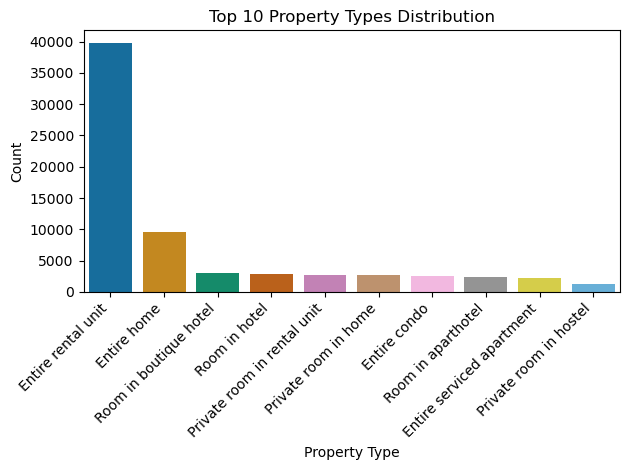

In [24]:
top10_property_types = df['property_type'].value_counts().nlargest(10)
sns.set_palette("colorblind")

sns.barplot(x=top20_property_types.index, y=top20_property_types.values)

plt.title('Top 10 Property Types Distribution')
plt.xlabel('Property Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()  
plt.show()

In [18]:
df["room_type"].value_counts()

room_type
Entire home/apt    57570
Private room       14274
Shared room         1569
Hotel room          1562
Name: count, dtype: int64

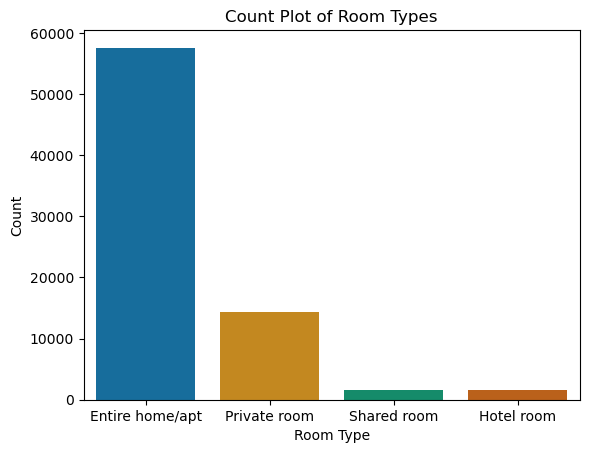

In [25]:
sns.countplot(x='room_type', data=df, palette='colorblind')

plt.title('Count Plot of Room Types')
plt.xlabel('Room Type')
plt.ylabel('Count')

plt.show()

* Exploring frequetly reviewed properties

In [56]:
df['listing_id'].value_counts()

popular = df['listing_id'].value_counts()
popular

listing_id
27750681              363
44125369              340
847456265351637680    269
49084102              244
50381026              178
                     ... 
48270489                1
19061679                1
43806377                1
39953244                1
26171785                1
Name: count, Length: 6657, dtype: int64

In [57]:
popular.nunique()

92

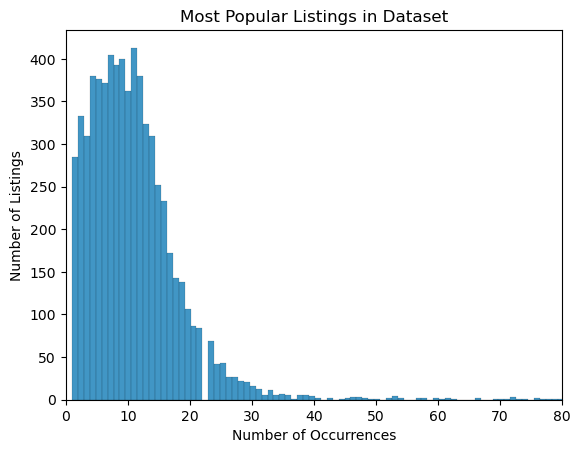

In [28]:
ax = sns.histplot(df["listing_id"].value_counts())
plt.xlim(0, 80) 
plt.xlabel('Number of Occurrences')
plt.ylabel('Number of Listings')
plt.title('Most Popular Listings in Dataset')
plt.show()

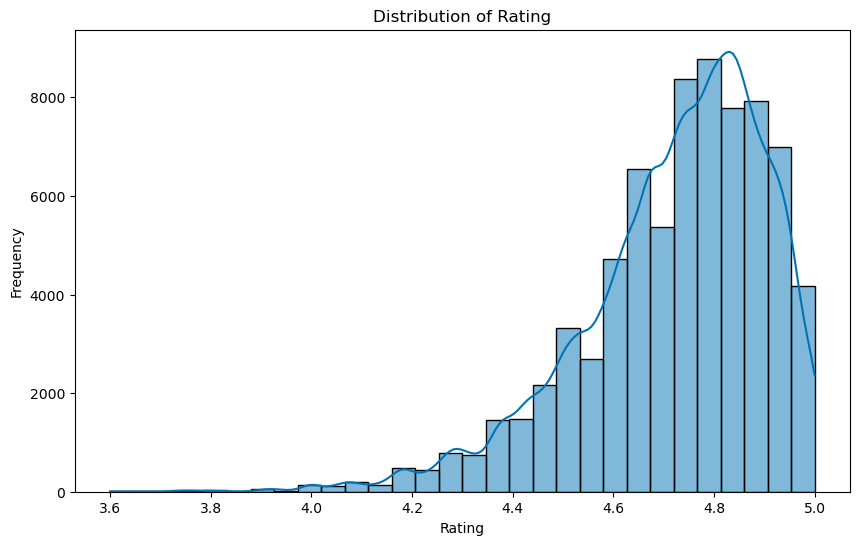

In [26]:
plt.figure(figsize=(10, 6))

# Distribution plot for review scores rating
sns.histplot(df['rating'], bins=30, kde=True)

plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Frequency')

plt.show()


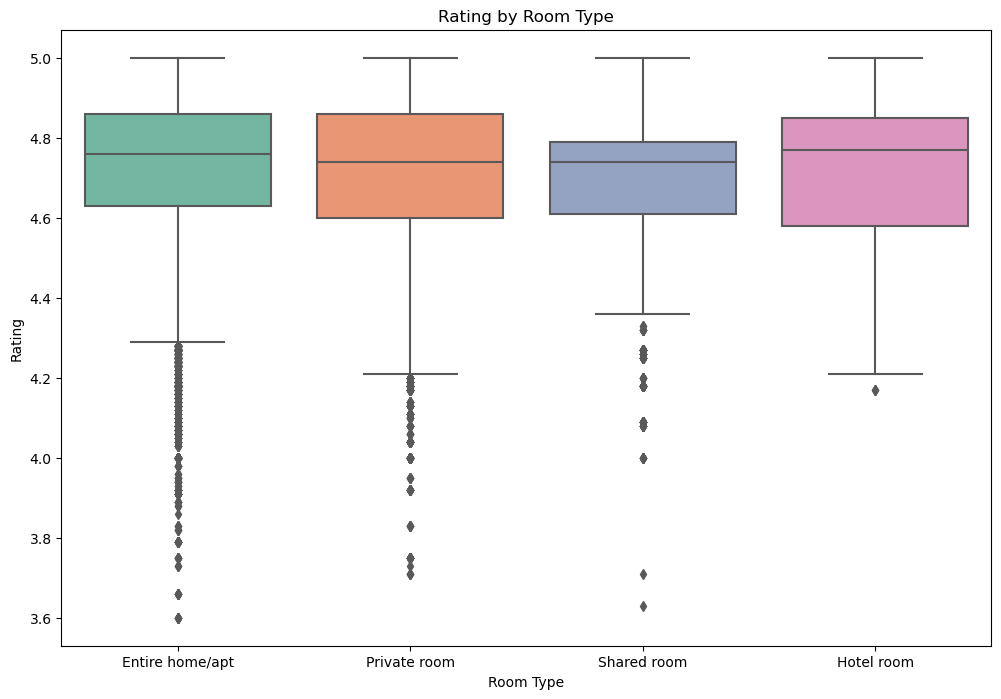

In [27]:
# Box plot of review scores rating by room type
plt.figure(figsize=(12, 8))
sns.boxplot(x='room_type', y='rating', data=df, palette='Set2')

plt.title('Rating by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Rating')

plt.show()

In [ ]:
#sns.pairplot(df[['number_of_reviews', 'review_scores_rating', 'beds']])
#plt.suptitle('Pair Plot of Numerical Variables', y=1.02)
#plt.show()


* For heatmap
import folium
from folium.plugins import HeatMap

Assuming 'latitude' and 'longitude' are the names of the columns in your filtered_df
latitude_column = 'latitude'
longitude_column = 'longitude'

Create a base map centered around Tokyo
tokyo_coordinates = [35.6895, 139.6917]
tokyo_map = folium.Map(location=tokyo_coordinates, zoom_start=12, lang='en')

Add a heatmap layer based on the latitude and longitude of the listings
HeatMap(filtered_df[[latitude_column, longitude_column]].values, radius=15).add_to(tokyo_map)

Save the map as an HTML file
tokyo_map.save('tokyo_heatmap.html')

Display the map (optional)
tokyo_map

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74975 entries, 283 to 451235
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   listing_id              74975 non-null  int64         
 1   date                    74975 non-null  datetime64[ns]
 2   reviewer_name           74975 non-null  object        
 3   comments                74965 non-null  object        
 4   listing_url             74975 non-null  object        
 5   name                    74975 non-null  object        
 6   description             74975 non-null  object        
 7   neighborhood_overview   54749 non-null  object        
 8   picture_url             74975 non-null  object        
 9   neighbourhood           54749 non-null  object        
 10  neighbourhood_cleansed  74975 non-null  object        
 11  latitude                74975 non-null  float64       
 12  longitude               74975 non-null  float64 

* Exploring price per night column

In [31]:
df['price']

0        $12,000.00
1        $12,000.00
2        $12,000.00
3         $8,902.00
4         $8,902.00
            ...    
74970    $27,714.00
74971    $27,714.00
74972    $27,714.00
74973    $27,714.00
74974    $27,714.00
Name: price, Length: 74975, dtype: object

In [34]:
# Clean and convert 'price' column to numeric format
df['price'] = pd.to_numeric(df['price'].replace('[^\d.]', '', regex=True), errors='coerce')

# Assuming exchange rate of 1 JPY = 0.0091 USD
exchange_rate = 0.0091

# Convert 'price' column to USD
df['price_in_usd'] = df['price'] * exchange_rate

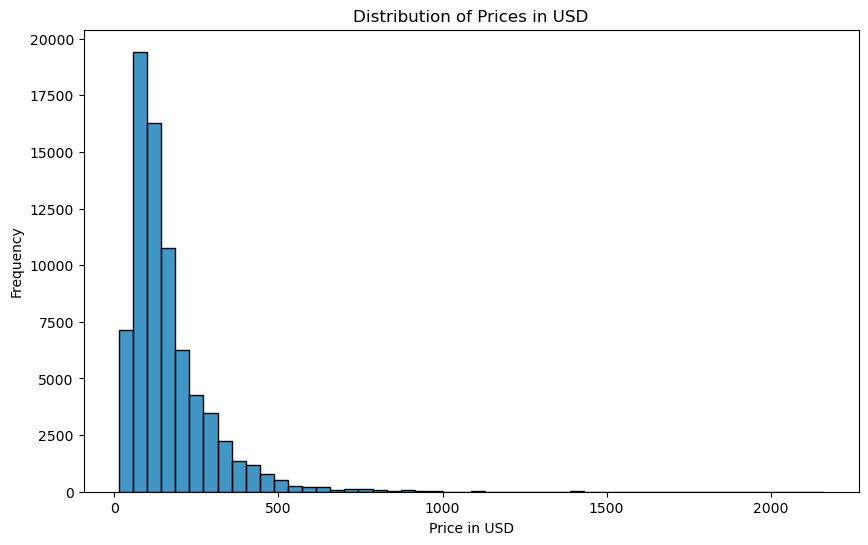

In [36]:
plt.figure(figsize=(10, 6))
sns.histplot(df['price_in_usd'], bins=50)
plt.title('Distribution of Prices in USD')
plt.xlabel('Price in USD')
plt.ylabel('Frequency')
plt.show()

In [37]:
average_price_by_category = df.groupby('property_type')['price_in_usd'].mean().sort_values(ascending=False)
print(average_price_by_category)

property_type
Private room in resort                607.097400
Treehouse                             426.398700
Entire villa                          368.764592
Farm stay                             359.841300
Room in serviced apartment            337.750228
Entire vacation home                  329.697630
Entire home                           287.026278
Entire cottage                        278.196100
Entire bungalow                       276.903900
Entire place                          268.185938
Barn                                  248.157000
Earthen home                          227.500000
Room in aparthotel                    186.801253
Entire cabin                          182.000000
Room in boutique hotel                173.733700
Hut                                   171.808838
Entire condo                          161.942295
Tiny home                             161.304072
Entire townhouse                      160.337607
Entire rental unit                    151.718476
Entire

* investigate the relationship between prices and review scores. Is there a correlation between higher prices and better review scores?

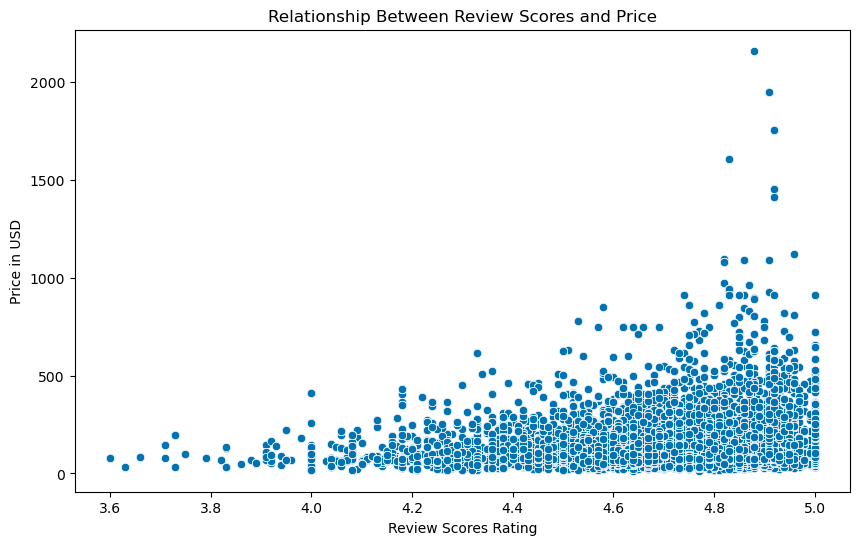

In [39]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='rating', y='price_in_usd', data=df)
plt.title('Relationship Between Review Scores and Price')
plt.xlabel('Review Scores Rating')
plt.ylabel('Price in USD')
plt.show()


* * make y axis bigger and focus on removing the outliers, zoom in on the graph.

In [41]:
amenities_counts = df['amenities'].apply(lambda x: pd.Series(eval(x))).stack().value_counts()
print(amenities_counts)


Hair dryer               74249
Essentials               73369
Smoke alarm              72730
Shampoo                  69176
Hangers                  68737
                         ...  
P&G body soap                1
SHISEIDO conditioner         1
MARKS&WEB conditioner        1
汎用品 conditioner              1
Fast wifi – 305 Mbps         1
Name: count, Length: 1622, dtype: int64


In [46]:
top_n_amenities = 10 
top_amenities_counts = amenities_counts.head(top_n_amenities)
print(top_amenities_counts)


Hair dryer           74249
Essentials           73369
Smoke alarm          72730
Shampoo              69176
Hangers              68737
Hot water            67183
Wifi                 67001
Fire extinguisher    65507
Refrigerator         64098
Microwave            64012
Name: count, dtype: int64


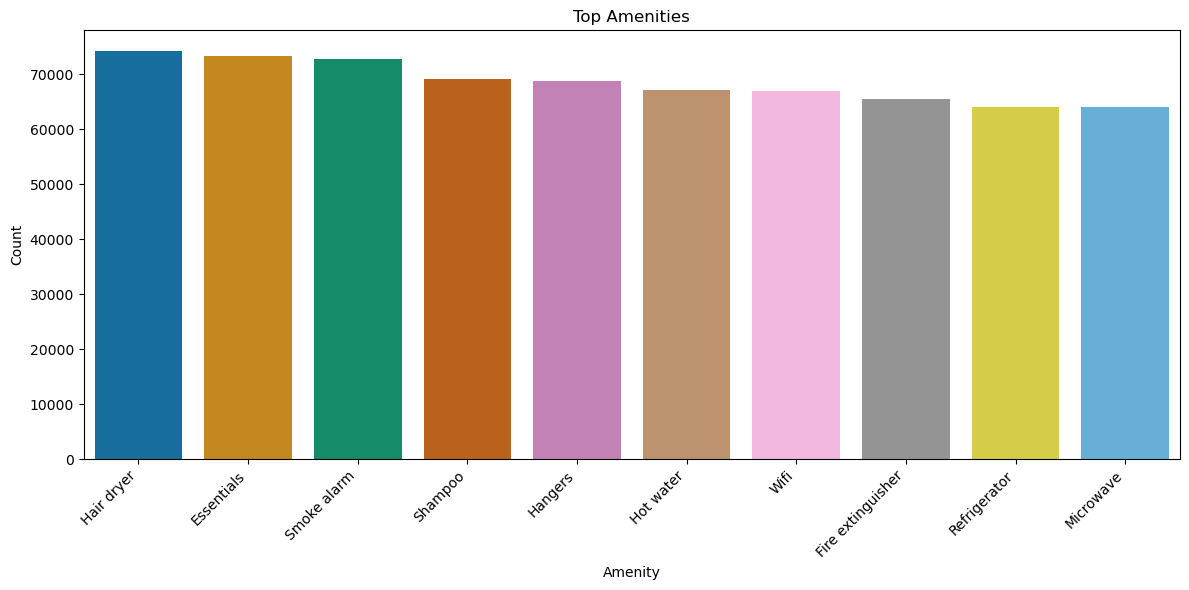

In [47]:
sns.set_palette("colorblind")
plt.figure(figsize=(12, 6))

sns.barplot(x=top_amenities_counts.index, y=top_amenities_counts.values)

plt.xticks(rotation=45, ha='right')

plt.title('Top Amenities')
plt.xlabel('Amenity')
plt.ylabel('Count')
plt.tight_layout() 
plt.show()


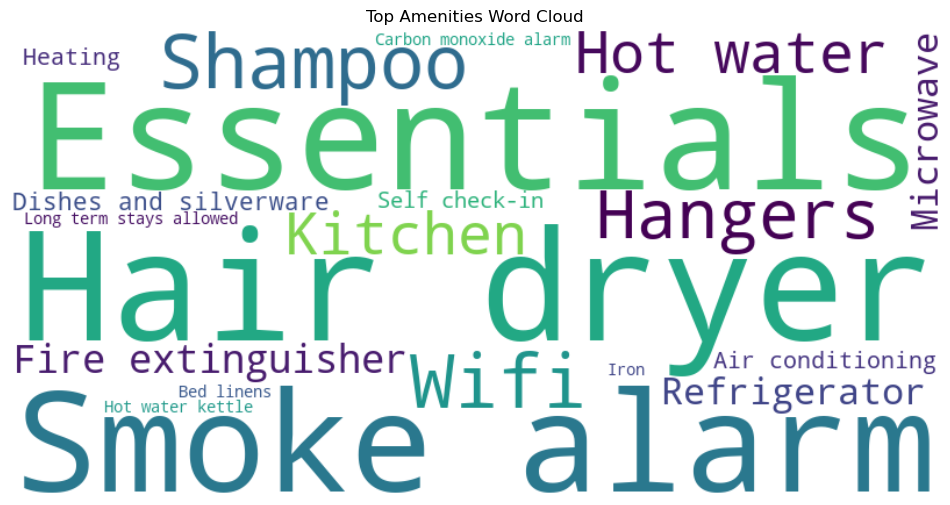

In [64]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_amenities_counts)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis labels
plt.title('Top Amenities Word Cloud')
plt.show()


In [65]:
total_listings = len(filtered_df)
amenities_percentages = (amenities_counts / total_listings) * 100
print(amenities_percentages)

Hair dryer                                          97.587888
Essentials                                          95.932769
Smoke alarm                                         95.804465
Shampoo                                             89.787016
Wifi                                                88.978702
                                                      ...    
17" TV                                               0.012830
32" TV with Netflix, Fire TV, Amazon Prime Video     0.012830
Paid parking on premises – 1 space                   0.012830
Fast wifi – 553 Mbps                                 0.012830
Fast wifi – 342 Mbps                                 0.012830
Name: count, Length: 1879, dtype: float64


* Convert amenities from categorical to numerical

In [72]:
filtered_df["number_of_reviews"].value_counts()

number_of_reviews
1      365
2      281
3      258
4      215
6      200
      ... 
316      1
547      1
254      1
319      1
272      1
Name: count, Length: 344, dtype: int64

In [25]:
df['reviewer_id'].nunique()

67632

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74975 entries, 0 to 74974
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   listing_id              74975 non-null  int64         
 1   date                    74975 non-null  datetime64[ns]
 2   reviewer_id             74975 non-null  int64         
 3   reviewer_name           74975 non-null  object        
 4   comments                74965 non-null  object        
 5   listing_url             74975 non-null  object        
 6   name                    74975 non-null  object        
 7   description             74975 non-null  object        
 8   neighborhood_overview   54749 non-null  object        
 9   picture_url             74975 non-null  object        
 10  neighborhood            74975 non-null  object        
 11  latitude                74975 non-null  float64       
 12  longitude               74975 non-null  float6

In [49]:

# Filter the DataFrame to show listings where the same reviewer reviewed multiple properties
duplicated_reviewers = df[df.duplicated('reviewer_id', keep=False)]

# Display the relevant columns for these listings
relevant_columns = ['reviewer_id', 'listing_id', 'number_of_reviews', 'rating']
result = duplicated_reviewers[relevant_columns].sort_values(by='reviewer_id')
result.head()


,reviewer_id,listing_id,number_of_reviews,rating
4989,51865,16409316,240,4.85
58897,51865,628785146348461723,19,4.89
32945,56895,40093874,53,4.83
47211,56895,47151937,46,4.96
23172,82275,33697267,83,4.83


# Data processing for Modeling

In [50]:
# Select only the relevant columns and selecting a random sample
# Model crashed while running on the full data
sampled_df = df.sample(frac=0.5)
new_df = sampled_df[['reviewer_id', 'listing_id', 'rating']]

In [51]:
# Define the rating scale
reader = Reader(rating_scale=(1, 5)) 

# Load the dataset into Surprise
data = Dataset.load_from_df(new_df, reader)


In [53]:
full_dataset = data.build_full_trainset()

#view the number of users and items
print('Number of users: ', full_dataset.n_users, '\n')
print('Number of items: ', full_dataset.n_items)

Number of users:  35562 

Number of items:  6344


In [54]:
trainset, testset = train_test_split(data, test_size=0.2,random_state=42)

In [55]:
#function for outputting the accuracy predictions on an algorithm

def train_and_test_pred (algo, trainset, testset): 
    algo.fit(trainset)
   
    train_predictions = algo.test(trainset.build_testset())
    print('biased accuracy on train set: ')
    print(accuracy.rmse(train_predictions))
    print(accuracy.mae(train_predictions))
    test_predictions = algo.test(testset)
    print('unbiased accuracy on test set: ')
    print(accuracy.rmse(test_predictions))
    print(accuracy.mae(test_predictions))

# Baseline Model - KNN

In [56]:
baseline_model = KNNBasic()
train_and_test_pred(baseline_model, trainset, testset)

Computing the msd similarity matrix...
Done computing similarity matrix.
biased accuracy on train set: 
RMSE: 0.0000
7.713535529332599e-16
MAE:  0.0000
3.2923906274779233e-16
unbiased accuracy on test set: 
RMSE: 0.1862
0.18617621126392492
MAE:  0.1447
0.1446581060940472


In [57]:
#Scores for KNN Basic via cross validation
cv_knn_basic = cross_validate(baseline_model, data)
print("mean fit time", np.mean(cv_knn_basic['fit_time']))
print("mean test time", np.mean(cv_knn_basic['test_time']))
print("mean test rmse", np.mean(cv_knn_basic['test_rmse']))

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
mean fit time 3.7459808826446532
mean test time 0.0342404842376709
mean test rmse 0.18588509743774212


# SVD

In [58]:
## Scores for Baseline SVD Crossvalidation

svd = SVD()
cv_svd = cross_validate(svd, data)
print("mean fit time", np.mean(cv_svd['fit_time']))
print("mean test time", np.mean(cv_svd['test_time']))
print("mean test rmse", np.mean(cv_svd['test_rmse']))

mean fit time 0.19588522911071776
mean test time 0.015542364120483399
mean test rmse 0.13283671385355134


In [59]:
train_and_test_pred(svd, trainset, testset)

biased accuracy on train set: 
RMSE: 0.1066
0.10658352023580242
MAE:  0.0810
0.08096522765849218
unbiased accuracy on test set: 
RMSE: 0.1334
0.13335586683909462
MAE:  0.0958
0.09582562203648304


In [60]:
# performing a gridsearch with SVD

params = {
    'n_factors': [100,150,200],
    'n_epochs': [20,80,100],
    'lr_all': [0.008,0.01],
    'reg_all': [0.07,0.1]
}

SVD_grid = GridSearchCV(SVD, param_grid = params, cv=5)
SVD_grid.fit(data)

In [ ]:
#view grid search results
print(SVD_grid.best_params)
print(SVD_grid.best_score)

In [62]:
## choose the best algo
svd_best_algo = SVD_grid.best_estimator['rmse']

In [ ]:
train_and_test_pred(svd_best_algo, trainset, testset)

In [ ]:
#Scores for Best SVD via cross validation
cv_best_svd = cross_validate(svd_best_algo, data)
print("mean fit time", np.mean(cv_best_svd['fit_time']))
print("mean test time", np.mean(cv_best_svd['test_time']))
print("mean test rmse", np.mean(cv_best_svd['test_rmse']))